In [28]:
## SI FIGURE

# Created December 27, 2021
# Updated February 24, 2022
import sys
sys.path.append('../')

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
# mpl formatting
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl_configs)
import methods.ax_methods as ax_methods
import numpy as np; rnd = np.random.default_rng()
import scipy.stats
import pickle


In [29]:
import methods.filter_lineages as fl

with open('../figure1_muller_and_transition/10biggest_indices.pkl', 'rb') as f:
    muller_lineage_dict = pickle.load(f)


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28313/1760053445.py:32: RuntimeWarning: divide by zero encountered in true_divide
  lineage_mice_fold_changes = lineage_mice_freqs / freqs0[index]
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28313/1760053445.py:32: RuntimeWarning: divide by zero encountered in true_divide
  lineage_mice_fold_changes = lineage_mice_freqs / freqs0[index]
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28313/1760053445.py:51: RuntimeWarning: invalid value encountered in double_scalars
  lineage_err_below = lineage_median - np.min(lineage_mice_fold_changes)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28313/1760053445.py:52: RuntimeWarning: invalid value encountered in double_scalars
  lineage_err_above = np.max(lineage_mice_fold_changes) - lineage_median
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_28313/1760053445.py:32: RuntimeWarning: divide by zero encountered in true_divide
  lineage_mice_

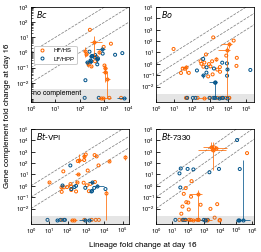

In [35]:
fig = plt.figure(figsize=(4, 4))
outer = mpl.gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1,0.01, 1], width_ratios=[1,0.01,1])
outer_ax = fig.add_subplot(outer[:, :])
outer_ax.set_ylabel('Gene complement fold change at day 16', fontsize=8, labelpad=10)
outer_ax.set_xlabel('Lineage fold change at day 16', fontsize=8, labelpad=10)
ax_methods.turn_off_ax(outer_ax)

for b, bac in enumerate(bacteria):
    read_array = fl.bac_read_arrays[bac][:, fl.bac_nonwu_indices[bac]]
    row_ids = fl.bac_row_ids[bac]

    ax = fig.add_subplot(outer[2*(b//2), 2*(b%2)])
    reads0 = read_array[0]
    freqs0 = reads0 / reads0.sum()

    for mice, diet in [([6,7,8,9,10], 'HF'), ([16, 18, 19,], 'LF')]:
        mice = diet_mice_map[diet]

        mice_reads = read_array[ [row_ids[(mouse, 16)] for mouse in mice]]
        mice_freqs = np.einsum('ij, i->ij', mice_reads, mice_reads.sum(axis=1)**-1.)

        indices_mice_map = {}
        for m, mouse in enumerate(mice):
            mouse_large_lineage_indices = muller_lineage_dict[bac][mouse]
            for index in mouse_large_lineage_indices:
                if index not in indices_mice_map:
                    indices_mice_map[index] = []
                indices_mice_map[index].append(m)

        for index, mice_subset in indices_mice_map.items():
            lineage_mice_freqs = mice_freqs[indices_mice_map[index], index]
            lineage_mice_fold_changes = lineage_mice_freqs / freqs0[index]

            gene_complement_mice_fold_changes = []
            for m in mice_subset:
                gc_f0, gc_f1 = fl.calc_gene_complement_freqs(bac, [index], freqs0, mice_freqs[m], cutoff=0)

                is_zero = gc_f1 == 0
                gc_f1[is_zero] = gc_f0[is_zero] * 10**-3

                if np.any(gc_f0.mask):
                    gc_f0[gc_f0.mask] = 1    ## intergenic
                    gc_f1[gc_f1.mask] = 10**-3

                gene_complement_mice_fold_changes.append( gc_f1[0]/gc_f0[0] )

            if len(mice_subset) == 1:
                ax.scatter( lineage_mice_fold_changes, gene_complement_mice_fold_changes, color=DIET_COLORS[diet], marker='.', facecolors='none')
            else:
                lineage_median = np.median(lineage_mice_fold_changes)
                lineage_err_below = lineage_median - np.min(lineage_mice_fold_changes)
                lineage_err_above = np.max(lineage_mice_fold_changes) - lineage_median
                gene_median = np.median(gene_complement_mice_fold_changes)
                gene_err_below =gene_median - np.min(gene_complement_mice_fold_changes)
                gene_err_above = np.max(gene_complement_mice_fold_changes) - gene_median

                ax.errorbar( x=[lineage_median], xerr=np.array([[lineage_err_below], [lineage_err_above]]),
                             y=[gene_median], yerr=np.array([[gene_err_below], [gene_err_above]]), color=DIET_COLORS[diet], marker='.', mfc='none')

        # if 'plot median gene':
            # all_gene_fcs = []
            # all_reads_array = fl.bac_read_arrays[bac][ [0]+[row_ids[(mouse, 16)] for mouse in mice] ]
            # for gene in fl.bac_gene_meta_dict[bac].keys():
            #     if gene not in wu_genes[bac][diet]:
            #         gene_indices = fl.bac_gene_meta_dict[bac][gene]['indices']
            #         gene_day0_reads = all_reads_array[0][gene_indices].sum()
            #         gene_mice_reads = all_reads_array[1:, gene_indices].sum(axis=1)
            #
            #
            #         gene_day0_freqs = gene_day0_reads / reads0.sum()
            #
            #         gene_mice_freqs = gene_mice_reads / mice_reads.sum(axis=1)
            #
            #         all_gene_fcs.append( gene_mice_freqs / gene_day0_freqs )
            # all_gene_fcs = np.array(all_gene_fcs)
            # isnan = np.isnan(all_gene_fcs)
            # all_gene_fcs[isnan] = -np.inf
            #
            # median_gene_fcs = np.median(all_gene_fcs, axis=0)
            # max_gene_fcs = np.max(median_gene_fcs)
            # min_gene_fcs = np.min(median_gene_fcs)
            # ax.axhspan(min_gene_fcs, max_gene_fcs, color=DIET_COLORS[diet], alpha=0.2)

    # ax.axvline(1, color='black')
    # ax.axhline(1, color='black')


    ax.set_xscale('log')
    ax.set_yscale('log')
    if bac == 'BWH2':
        ax.set_xticks( [1, 10, 10**2, 10**3, 10**4] )
        ax.set_yticks( [10**-2, 10**-1, 1, 10, 10**2, 10**3])
    if bac in ['Bovatus', 'BtVPI']:
        ax.set_xticks( [1, 10, 10**2, 10**3, 10**4, 10**5] )
        ax.set_yticks( [10**-2, 10**-1, 1, 10, 10**2, 10**3, 10**4, 10**5])
    if bac == 'Bt7330':
        ax.set_xticks( [1, 10, 10**2, 10**3, 10**4, 10**5, 10**6] )
        ax.set_yticks( [10**-2, 10**-1, 1, 10, 10**2, 10**3, 10**4, 10**5])

    if bac == 'BWH2':
        ax.text(1.2, 1.5*10**-3, 'no complement', fontsize=7, color='black')
        ax.set_ylim(5*10**-4, ax.get_ylim()[1])
        ax.axhspan(ymin=0.8*10**-4, ymax=4*10**-3, color='grey', alpha=0.2, linewidth=0)
        ax.legend( [ax_methods.make_marker_obj(linewidth=0, marker='.', mfc='none', mec=DIET_COLORS[diet]) for diet in ['HF', 'LF']],
               ['HF/HS', 'LF/HPP'], loc=6, frameon=True, facecolor='white', framealpha=1)
    else:
        ax.set_ylim(4*10**-4, ax.get_ylim()[1])
        ax.axhspan(ymin=0.8*10**-4, ymax=2*10**-3, color='grey', alpha=0.2, linewidth=0)

    ax.set_xlim(ax.get_xlim())
    ax.tick_params(axis='both', labelsize=6)
    ax.text(0.05, 0.89, BAC_FORMAL_NAMES[bac], transform=ax.transAxes, fontsize=8)


    ax.plot(ax.get_xlim(), ax.get_xlim(), color='grey', linestyle='dashed', zorder=0)
    ax.plot(ax.get_xlim(), np.array(ax.get_xlim())/10, color='grey', linestyle='dashed', zorder=0)
    ax.plot(ax.get_xlim(), np.array(ax.get_xlim())/100, color='grey', linestyle='dashed', zorder=0)


#
fig.savefig(f'{biorxiv}/SI_day16_vs_gene.pdf')